# Types of recommendation systems:


- Collaborative filtering model: 
    - Based on feedbacks: 
        - explicit feedback(ratings, thumbup/thumdown) 
        - implicit feedback(book in shopping cart, numbner of episode watched in a TV show)
    - User-user similarities (people like you, also like "The Hobbit")
    - Item-item similarities (if you like "The Hobbit", you will also "The Lord of Rings")
    - User-item similarities : combined both approaches above and use *matrix facotrization* -> Best trained with Singular Value decomposition (SVD) 


- Content-based model:
    - similarities are calculated based on content based features (like the genre, duration of the movie )
     

- Hybrid recommender model:
    - combined collaborative filtering with content-based
    - Because Hybrid Deep Learning algorithms are non-linear, they are less prone to over-simplify a user’s tastes. They allow us to learn much finer interactions between users and items. 
    - Deep learning models can reveal more complex tastes over cross-domain data (predict a user's taste on music, movies and even dishes!?)


# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics

from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation
from sklearn.metrics.pairwise import pairwise_distances

import warnings
warnings.filterwarnings('ignore')

import os, sys
import re
from contextlib import contextmanager

In [2]:
# display full text in columns
pd.set_option('display.max_colwidth', -1)

# Load Data

In [3]:
books = pd.read_csv('data/BX-CSV-Dump/BX-Books.csv', sep=';', error_bad_lines=False, encoding="latin-1")
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']
users = pd.read_csv('data/BX-CSV-Dump/BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
users.columns = ['userID', 'Location', 'Age']
ratings = pd.read_csv('data/BX-CSV-Dump/BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
ratings.columns = ['userID', 'ISBN', 'bookRating']

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


In [4]:
books.info(), users.info(), ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   ISBN               271360 non-null  object
 1   bookTitle          271360 non-null  object
 2   bookAuthor         271359 non-null  object
 3   yearOfPublication  271360 non-null  object
 4   publisher          271358 non-null  object
 5   imageUrlS          271360 non-null  object
 6   imageUrlM          271360 non-null  object
 7   imageUrlL          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   userID    278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ 

(None, None, None)

# Clean Data & EDA

### Book data

In [5]:
books.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


In [6]:
books.drop(['imageUrlS', 'imageUrlM', 'imageUrlL'],axis=1,inplace=True)
books.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [7]:
books.yearOfPublication.unique() #mixed with string and int

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

In [8]:
books.loc[(books.yearOfPublication == 'DK Publishing Inc') | (books.yearOfPublication == 'Gallimard'), :]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\"";Michael Teitelbaum""",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-Marie Gustave Le ClÃ?Â©zio""",2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\"";James Buckley""",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg


In [9]:
books.loc[books.ISBN == '078946697X','yearOfPublication'] = 2000
books.loc[books.ISBN == '078946697X','bookAuthor'] = "Michael Teitelbaum"
books.loc[books.ISBN == '078946697X','publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '078946697X','bookTitle'] = "DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)"

In [10]:
books.loc[books.ISBN == '0789466953','yearOfPublication'] = 2000
books.loc[books.ISBN == '0789466953','bookAuthor'] = "James Buckley"
books.loc[books.ISBN == '0789466953','publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '0789466953','bookTitle'] = "DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)"

In [11]:
books.loc[books.ISBN == '2070426769','yearOfPublication'] = 2003
books.loc[books.ISBN == '2070426769','bookAuthor'] = "Jean-Marie Gustave Le ClÃ?Â©zio"
books.loc[books.ISBN == '2070426769','publisher'] = "Gallimard"
books.loc[books.ISBN == '2070426769','bookTitle'] = "Peuple du ciel, suivi de 'Les Bergers"

In [12]:
#convert some year dtype from string to int
books.yearOfPublication = pd.to_numeric(books.yearOfPublication, errors='coerce', downcast="integer")
print(sorted(books.yearOfPublication.unique()))

[0, 1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908, 1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021, 2024, 2026, 2030, 2037, 2038, 2050]


Text(0, 0.5, 'year of publication')

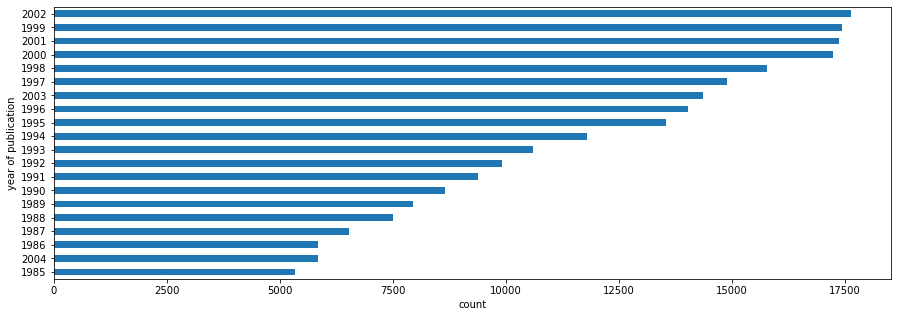

In [13]:
books.yearOfPublication.value_counts(ascending=True).tail(20).plot(kind='barh', figsize=(15, 5))
plt.xlabel("count")
plt.ylabel("year of publication")

In [14]:
# year between 1800 and 2022 is valid, which is 98% of the data 
books.loc[(books.yearOfPublication > 0) & (books.yearOfPublication <= 2022)].shape[0] / books.shape[0]

0.9829341096698113

In [15]:
books_filtered = books[(books.yearOfPublication > 0) & (books.yearOfPublication <= 2022)]
books_filtered 

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company
...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm)
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books
271357,006008667X,Lily Dale : The True Story of the Town that Talks to the Dead,Christine Wicker,2004,HarperSanFrancisco
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press


In [16]:
#strip leading and trail spaces in book titles
books_filtered.bookTitle = books_filtered.bookTitle.str.strip()

In [17]:
#cast dtype
books_filtered.ISBN.astype(str)
books_filtered.bookTitle.astype(str)
books_filtered.bookAuthor.astype(str)
books_filtered.bookAuthor.astype(str)

#drop 1 null value in bookAuthor and 2 null value in publisher
books_filtered = books_filtered[(~books_filtered.bookAuthor.isnull()) & (~books_filtered.publisher.isnull())]
books_filtered

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company
...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm)
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books
271357,006008667X,Lily Dale : The True Story of the Town that Talks to the Dead,Christine Wicker,2004,HarperSanFrancisco
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press


### User data

In [18]:
users.head()

,userID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [19]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   userID    278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [20]:
print(sorted(users.Age.unique()))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

In [21]:
users.loc[(users.Age > 100) | (users.Age < 10), 'Age'] = np.nan
#replacing NaNs with user age mean
users.Age = users.Age.fillna(users.Age.mean())

In [22]:
users.Age = users.Age.astype(np.int32)
# users.Location = users.Location.astype(str)
users.userID = users.userID.astype(str)

In [23]:
users.Location = users.Location.astype(str)

Text(0, 0.5, 'age')

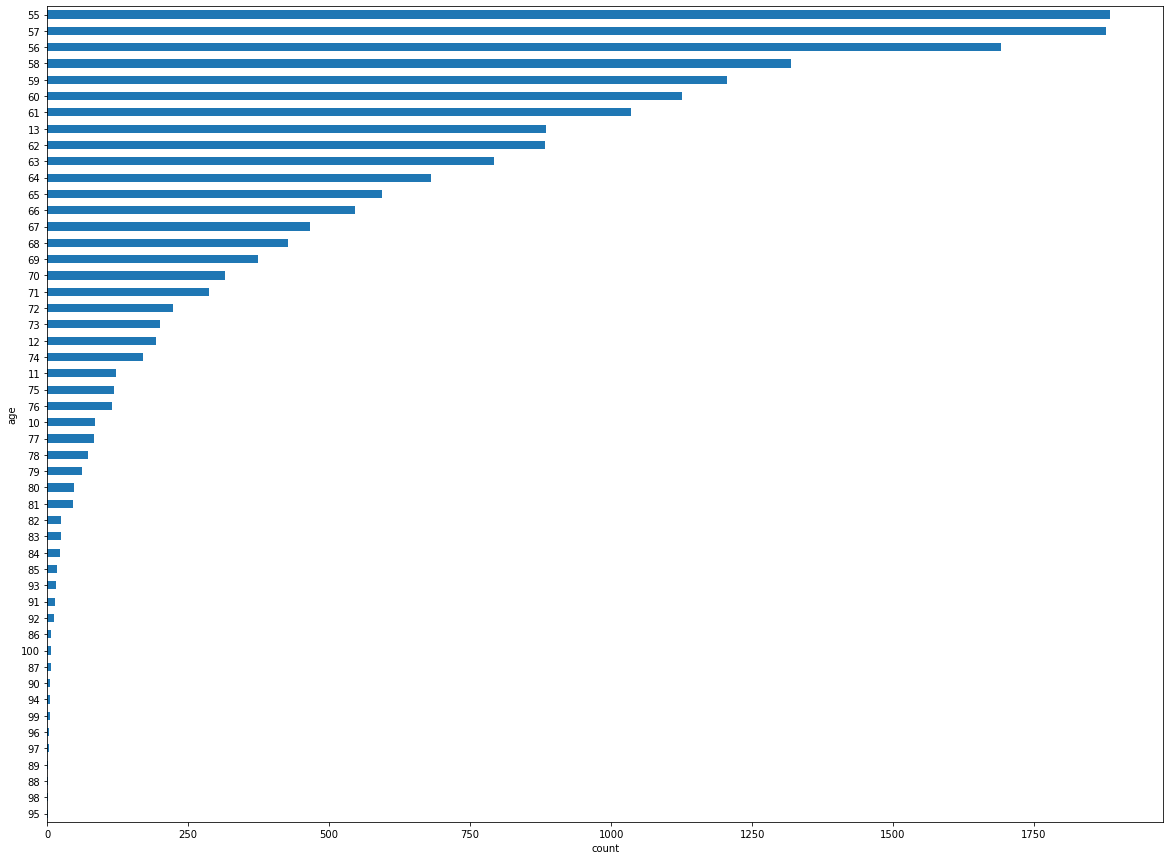

In [24]:
users.Age.value_counts(ascending=True).head(50).plot(kind='barh', figsize=(20, 15))
plt.xlabel("count")
plt.ylabel("age")

### Rating data

In [25]:
ratings.head()

,userID,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [26]:
ratings.info() #no nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   userID      1149780 non-null  int64 
 1   ISBN        1149780 non-null  object
 2   bookRating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [27]:
ratings.userID = ratings.userID.astype(str)

In [28]:
ratings.bookRating.value_counts()

0     716109
8     103736
10    78610 
7     76457 
9     67541 
5     50974 
6     36924 
4     8904  
3     5996  
2     2759  
1     1770  
Name: bookRating, dtype: int64

Text(0, 0.5, 'rating')

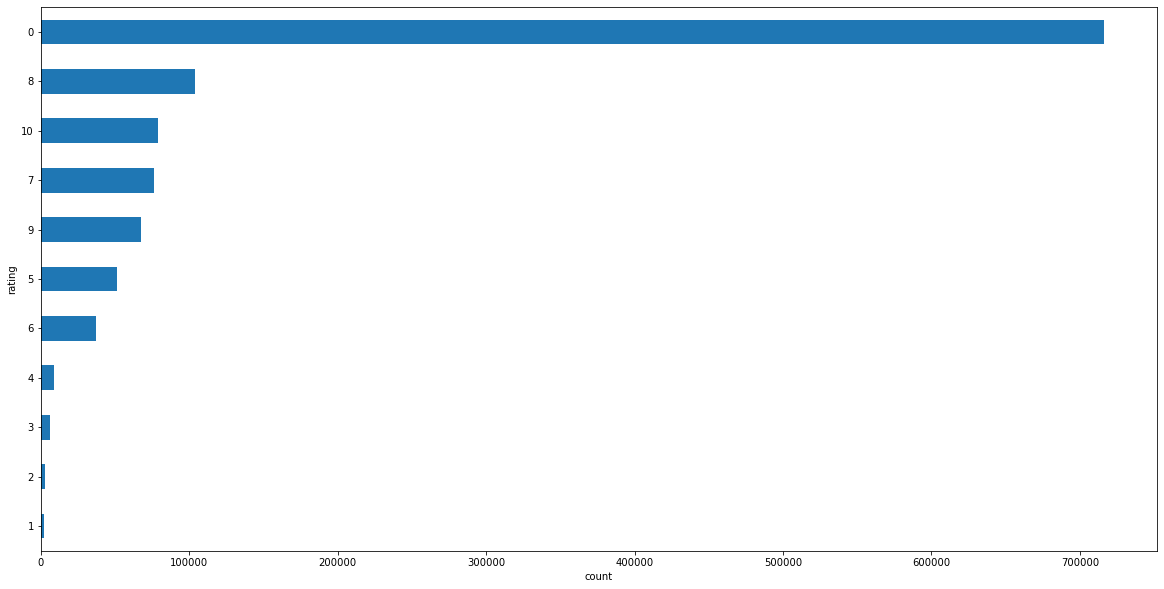

In [29]:
ratings.bookRating.value_counts(ascending = True).head(15).plot(kind='barh', figsize=(20, 10))
plt.xlabel("count")
plt.ylabel("rating")

### Corss check data

In [30]:
# filter the users who give ratings are also in the user table
ratings_filtered = ratings[ratings.userID.isin(users.userID)]
ratings_filtered

,userID,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [31]:
# filter that the books in ratings are also in book table
ratings_filtered = ratings_filtered[ratings_filtered.ISBN.isin(books.ISBN)]
ratings_filtered

,userID,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149774,276704,0876044011,0
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10


# Check Sparsity

In [32]:
#size of the user to book matrix: 
print("Num of users: ", users.shape[0])
print("Num of books: ", books.shape[0])
print("size of the user-item matrix: ", users.shape[0] * books.shape[0])

Num of users:  278858
Num of books:  271360
size of the user-item matrix:  75670906880


In [33]:
#calculate the parsity of matrix
sparsity = 1 - ratings_filtered.shape[0] / (users.shape[0] * books.shape[0])
print("the rating matrix has ", str(sparsity*100) + " % of sparsity")

the rating matrix has  99.99863734155898 % of sparsity


In [34]:
#Hence segragating implicit and explict ratings datasets
ratings_explicit = ratings_filtered[ratings_filtered.bookRating != 0]
ratings_implicit = ratings_filtered[ratings_filtered.bookRating == 0]

In [35]:
# ration of explicit ratings and implicit ratings
print("% explicit rating: ", round(ratings_explicit.shape[0]/ratings_filtered.shape[0] *100, 0))
print("% implicit rating: ", round(ratings_implicit.shape[0]/ratings_filtered.shape[0] *100, 0))


% explicit rating:  37.0
% implicit rating:  63.0


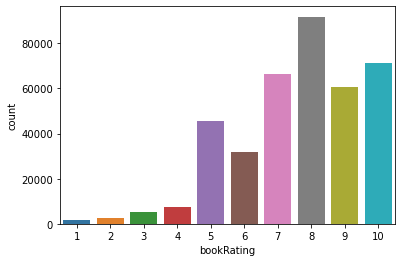

In [36]:
#for explicit 
sns.countplot(data=ratings_explicit , x='bookRating')
plt.show()

# Prepare user-item matrix

### Use explicit rating for matrix

In [37]:
ratings_explicit

,userID,ISBN,bookRating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
8,276744,038550120X,7
16,276747,0060517794,9
...,...,...,...
1149771,276704,0743211383,7
1149773,276704,0806917695,5
1149775,276704,1563526298,9
1149777,276709,0515107662,10


In [38]:
user_count = ratings_explicit['userID'].value_counts()
user_count

11676     6943
98391     5691
189835    1899
153662    1845
23902     1180
          ... 
114767    1   
114771    1   
114772    1   
114777    1   
276721    1   
Name: userID, Length: 68091, dtype: int64

In [39]:
ratings_explicit = ratings_explicit[ratings_explicit['userID'].isin(user_count[user_count >= 100].index)]

In [40]:
book_count = ratings_explicit['bookRating'].value_counts()
book_count

8     23904
10    22904
9     18554
7     15242
5     13314
6     6500 
4     1260 
3     772  
2     440  
1     381  
Name: bookRating, dtype: int64

In [41]:
ratings_explicit = ratings_explicit[ratings_explicit['bookRating'].isin(book_count[book_count >= 1000].index)]

In [42]:
#Creating ratings matrix from explicit ratings
ratings_matrix = ratings_explicit.pivot(index='userID', columns='ISBN', values='bookRating')
userID = ratings_matrix.index
ISBN = ratings_matrix.columns
print(ratings_matrix.shape)
ratings_matrix.head()

(449, 65725)


ISBN,0000913154,0001046438,000104687X,0001047213,0001047973,000104799X,0001048082,0001053736,0001053744,0001055607,...,B000092Q0A,B00009EF82,B00009NDAN,B0000DYXID,B0000T6KHI,B0000VZEJQ,B0000X8HIE,B00013AX9E,B0001I1KOG,B000234N3A
userID,,,,,,,,,,,,,,,,,,,,,
100459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0
101209,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
#new size of the user to book matrix: 
print("Num of users in matrix: ", ratings_matrix.shape[0])
print("Num of books in matrix: ", ratings_matrix.shape[1])
print("size of the new user-item matrix: ", ratings_matrix.shape[0] * ratings_matrix.shape[0])

Num of users in matrix:  449
Num of books in matrix:  65725
size of the new user-item matrix:  201601


### fillna and transpose
- we can't use NaNs to train the model, since we need to use non-zero numbers to calculate the similarities. so we replace them by 0
- transpose the matrix for modeling

In [44]:
ratings_matrix.fillna(0, inplace = True)
ratings_matrix = ratings_matrix.astype(np.int32)

In [45]:
ratings_matrix

ISBN,0000913154,0001046438,000104687X,0001047213,0001047973,000104799X,0001048082,0001053736,0001053744,0001055607,...,B000092Q0A,B00009EF82,B00009NDAN,B0000DYXID,B0000T6KHI,B0000VZEJQ,B0000X8HIE,B00013AX9E,B0001I1KOG,B000234N3A
userID,,,,,,,,,,,,,,,,,,,,,
100459,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100906,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
101209,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101606,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101851,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96448,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97754,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97874,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
ratings_matrix.T

userID,100459,100906,101209,101606,101851,102359,102647,102702,102967,104399,...,94951,95010,95359,95902,95932,96448,97754,97874,98391,98758
ISBN,,,,,,,,,,,,,,,,,,,,,
0000913154,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0001046438,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000104687X,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0001047213,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0001047973,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B0000VZEJQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B0000X8HIE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B00013AX9E,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
books_filtered[books_filtered.ISBN == "0000913154"]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
254249,0000913154,The Way Things Work: An Illustrated Encyclopedia of Technology,C. van Amerongen (translator),1967,Simon &amp; Schuster


In [48]:
ratings_matrix_pivot = ratings_matrix.T
ratings_matrix_pivot

userID,100459,100906,101209,101606,101851,102359,102647,102702,102967,104399,...,94951,95010,95359,95902,95932,96448,97754,97874,98391,98758
ISBN,,,,,,,,,,,,,,,,,,,,,
0000913154,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0001046438,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000104687X,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0001047213,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0001047973,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B0000VZEJQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B0000X8HIE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B00013AX9E,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Use book title instead of ISBN
- matrxi join book table

In [49]:
ratings_matrix_pivot.index = ratings_matrix_pivot.join(books_filtered.set_index('ISBN'))['bookTitle']
# ratings_matrix_pivot = ratings_matrix_pivot.sort_index()
ratings_matrix_pivot

userID,100459,100906,101209,101606,101851,102359,102647,102702,102967,104399,...,94951,95010,95359,95902,95932,96448,97754,97874,98391,98758
bookTitle,,,,,,,,,,,,,,,,,,,,,
The Way Things Work: An Illustrated Encyclopedia of Technology,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NaN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"T.S. Eliot Reading \The Wasteland\"" and Other Poems""",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
The Fighting Man,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Brave New World,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Roald Dahl's Revolting Rhymes,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NaN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Modern Contemporary: Aspects of Art at MoMA Since 1980,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
ratings_matrix_pivot = ratings_matrix_pivot.sort_index()
ratings_matrix_pivot

userID,100459,100906,101209,101606,101851,102359,102647,102702,102967,104399,...,94951,95010,95359,95902,95932,96448,97754,97874,98391,98758
bookTitle,,,,,,,,,,,,,,,,,,,,,
!%@ (A Nutshell handbook),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
!Arriba! Comunicacion y cultura,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"!Trato hecho!: Spanish for Real Life, Combined Edition",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
!Yo!,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
$14 In The Bank (Cathy Collection),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NaN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NaN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
ratings_matrix_pivot = ratings_matrix_pivot[~ratings_matrix_pivot.index.isnull()]
ratings_matrix_pivot

userID,100459,100906,101209,101606,101851,102359,102647,102702,102967,104399,...,94951,95010,95359,95902,95932,96448,97754,97874,98391,98758
bookTitle,,,,,,,,,,,,,,,,,,,,,
!%@ (A Nutshell handbook),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
!Arriba! Comunicacion y cultura,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"!Trato hecho!: Spanish for Real Life, Combined Edition",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
!Yo!,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
$14 In The Bank (Cathy Collection),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
why I'm like this : True Stories,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Â¡Corre, perro, corre!",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Â¿Eres tu mi mamÃ¡?/Are You My Mother?,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
ratings_matrix_pivot.index

Index(['!%@ (A Nutshell handbook)', '!Arriba! Comunicacion y cultura',
       '!Trato hecho!: Spanish for Real Life, Combined Edition', '!Yo!',
       '$14 In The Bank (Cathy Collection)',
       '' Mein verwundetes Herz'. Das Leben der Lilli Jahn 1900 - 1944.',
       ''A Hell of a Place to Lose a Cow': An American Hitchhiking Odyssey',
       ''G' Is for Grafton : The World of Kinsey Millhone',
       ''Isms: a dictionary of words ending in -ism, -ology, and -phobia,: With some similar terms, arranged in subject order',
       ''N Sync',
       ...
       'the Devil Will Drag You Under', 'them (Modern Library)',
       'together by christmas', 'wet sand, raven tracks',
       'whataboutrick.com: a poetic tribute to Richard A. Ricci',
       'why I'm like this : True Stories', 'Â¡Corre, perro, corre!',
       'Â¿Eres tu mi mamÃ¡?/Are You My Mother?',
       'Ã?ngeles fugaces (Falling Angels)', 'Ã?Â?ber das Fernsehen.'],
      dtype='object', name='bookTitle', length=64861)

In [53]:
loc = ratings_matrix_pivot.loc["The Queen of the Damned (Vampire Chronicles (Paperback))"][:50]
loc

userID
100459    0
100906    0
101209    0
101606    8
101851    0
102359    0
102647    0
102702    0
102967    0
104399    0
104636    0
105028    8
105517    0
10560     0
105979    0
106007    0
107784    0
107951    0
109574    0
109901    0
109955    0
110483    0
110912    0
110934    0
110973    0
112001    0
113270    0
113519    0
114368    5
114868    0
114988    0
115002    0
115003    0
116599    0
11676     0
117384    0
11993     0
120565    0
122429    0
122793    0
123094    8
123608    0
123883    0
123981    0
12538     0
125519    0
125774    0
126492    8
126736    0
127200    0
Name: The Queen of the Damned (Vampire Chronicles (Paperback)), dtype: int32

# Build Model: 

- Collaborative Filtering Based Recommender
- Item-based recommender - find similiar books and recommend to users
- Use KNN to find k most similar books
- Default params: 
    - metric = 'cosine'
    - algorithm = 'brute'
    - k = 5

### Test

In [54]:
global metric,k 
metric = 'cosine'
algorithm = 'brute'
k = 5
similarities = []
indices = []

In [55]:
model_knn = NearestNeighbors(metric = metric, algorithm = algorithm)
model_knn.fit(ratings_matrix_pivot.values)

NearestNeighbors(algorithm='brute', metric='cosine')

In [56]:
title = 'The Queen of the Damned (Vampire Chronicles (Paperback))'
ratings_matrix_pivot.loc[title].values

array([ 0,  0,  0,  8,  0,  0,  0,  0,  0,  0,  0,  8,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  5,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  8,  0,  0,  0,  0,  0,  0,  8,  0,  0,  0,
        0,  0,  0,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  7,  0,
        0,  0,  0,  0,  0,  0,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  5,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  7,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  7,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [57]:
distances, indices = model_knn.kneighbors([ratings_matrix_pivot.loc[title].values], n_neighbors = k+1)
# k+1 bc returned value will be including itself
similarities = 1 - distances.flatten()

In [58]:
similarities

array([1.        , 0.59347575, 0.56437782, 0.41117188, 0.40866895,
       0.38423836])

In [59]:
indices

array([[54726, 56629, 57373, 24628, 48872, 24429]])

In [60]:
ratings_matrix_pivot.iloc[indices[0]].index.values

array(['The Queen of the Damned (Vampire Chronicles (Paperback))',
       'The Tale of the Body Thief (Vampire Chronicles (Paperback))',
       'The Vampire Lestat (Vampire Chronicles, Book II)',
       'Interview with the Vampire',
       "The Doctor's Wife (Japan's Women Writers)", 'Inferno (Mentor)'],
      dtype=object)

In [61]:
pd.DataFrame({
    'title'   : ratings_matrix_pivot.iloc[indices[0]].index.values,
    'similarities': similarities
}).sort_values(by='similarities', ascending=False)

,title,similarities
0,The Queen of the Damned (Vampire Chronicles (Paperback)),1.000000
1,The Tale of the Body Thief (Vampire Chronicles (Paperback)),0.593476
2,"The Vampire Lestat (Vampire Chronicles, Book II)",0.564378
3,Interview with the Vampire,0.411172
4,The Doctor's Wife (Japan's Women Writers),0.408669
5,Inferno (Mentor),0.384238


### Create a function to output recommendations

In [62]:
# function to return recommended books 
def make_recommendation(matrix, model, k, title):
  try: 
    book = matrix.loc[title]
  except KeyError as e:
    print('Cannot find the book', e, 'in database!')
    return

  distance, indice = model.kneighbors([book.values], n_neighbors=k+1)
  similarities = 1 - distance.flatten()
  recommended_books = pd.DataFrame({
      'title'   : matrix.iloc[indice[0]].index.values,
      'similarities': similarities}).sort_values(by='similarities', ascending=False)

  return [recommended_books]

In [63]:
make_recommendation(ratings_matrix_pivot, model_knn, 5, "The Queen of the Damned (Vampire Chronicles (Paperback))")

[                                                         title  similarities
 0  The Queen of the Damned (Vampire Chronicles (Paperback))     1.000000    
 1  The Tale of the Body Thief (Vampire Chronicles (Paperback))  0.593476    
 2  The Vampire Lestat (Vampire Chronicles, Book II)             0.564378    
 3  Interview with the Vampire                                   0.411172    
 4  The Doctor's Wife (Japan's Women Writers)                    0.408669    
 5  Inferno (Mentor)                                             0.384238    ]

In [64]:
make_recommendation(ratings_matrix_pivot, model_knn, 5, "together by christmas")

[                                                    title  similarities
 0  together by christmas                                   1.000000    
 1  The Baby Plan  (9 Months Later)                         0.936063    
 2  Love With the Proper Husband (Avon Historical Romance)  0.907767    
 3  Prescribed Danger (Dr. Rhea Lynch Novels)               0.838978    
 4  Ecstasy                                                 0.838978    
 5  He's Got to Go                                          0.838962    ]